We are looking at the DNA sequences, made up of nucleotides (ACGT), that are essentially a language for directing the actions of the body. The sections (subsequences) of the language encode genes and families of genes. To interpret this language, it seems like NLP (natural language processing) would be an appropriate machine learning method, due to its analogous nature to languages.

Let's begin by exploring the DNA datasets.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from scipy.sparse import vstack
from sklearn.cluster import MiniBatchKMeans

Loading human, chimpanzee, and dog data

In [25]:
human_dna_path = '/Users/debane/Downloads/human.txt' 
chimp_dna_path = '/Users/debane/Downloads/chimpanzee.txt'
dog_dna_path = '/Users/debane/Downloads/dog.txt'

human_dna = pd.read_table(human_dna_path)
chimp_dna = pd.read_table(chimp_dna_path)
dog_dna = pd.read_table(dog_dna_path)

Text(0, 0.5, 'Count')

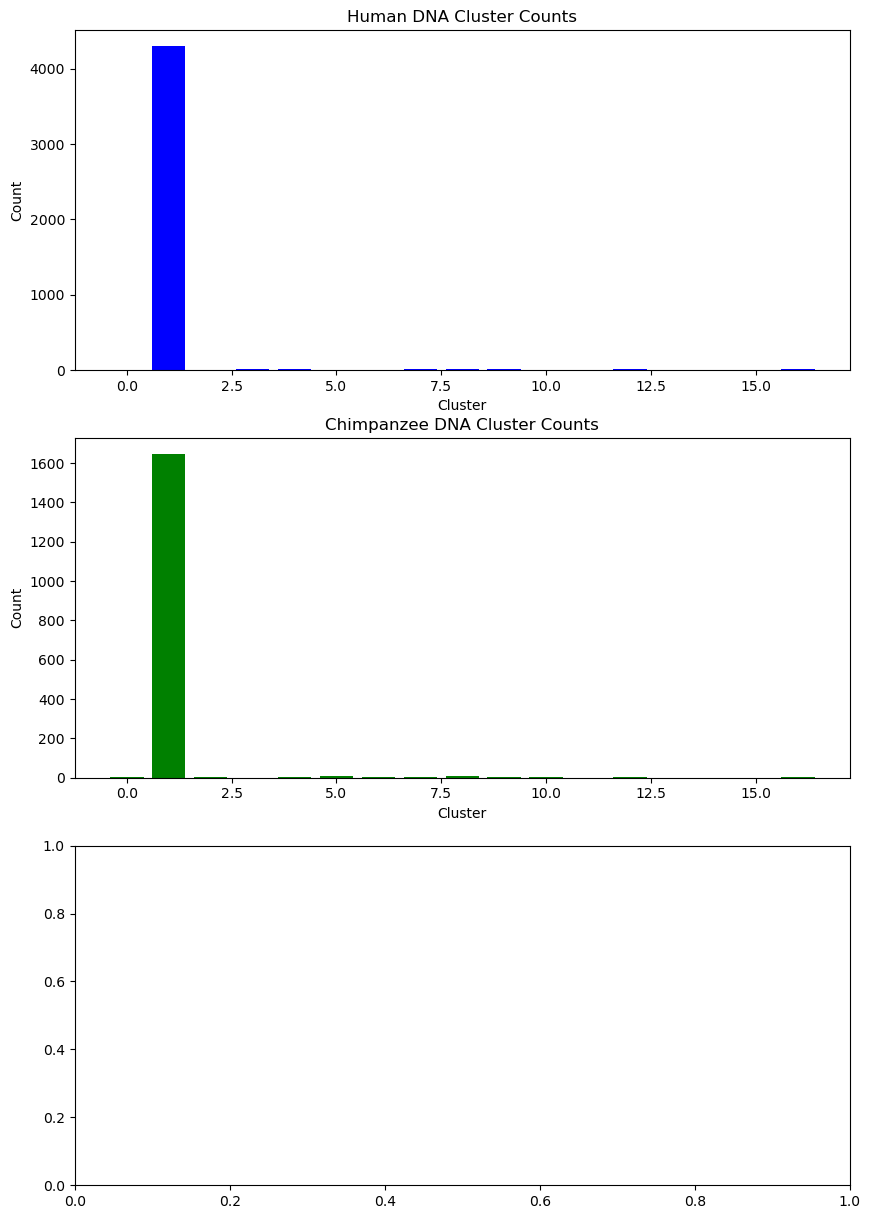

In [56]:
import matplotlib.pyplot as plt

# Converted cluster counts to dictionaries for plotting:
human_cluster_counts = {1: 4298, 16: 12, 7: 12, 3: 10, 8: 8, 12: 7, 4: 7, 9: 7, 5: 6, 2: 5, 0: 4, 10: 2, 13: 1, 6: 1}
chimp_cluster_counts = {1: 1646, 5: 6, 8: 6, 9: 5, 7: 4, 12: 4, 16: 3, 2: 3, 0: 2, 10: 1, 4: 1, 6: 1}
dog_cluster_counts = {1: 811, 6: 2, 11: 2, 10: 1, 14: 1, 15: 1, 2: 1, 8: 1}

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot for human DNA
axs[0].bar(human_cluster_counts.keys(), human_cluster_counts.values(), color='blue')
axs[0].set_title('Human DNA Cluster Counts')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Count')

# Plot for chimpanzee DNA
axs[1].bar(chimp_cluster_counts.keys(), chimp_cluster_counts.values(), color='green')
axs[1].set_title('Chimpanzee DNA Cluster Counts')
axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('Count')

# Plot for dog DNA
axs[2].bar(dog_cluster_counts.keys(), dog_cluster_counts.values(), color='red')
axs[2].set_title('Dog DNA Cluster Counts')
axs[2].set_xlabel('Cluster')
axs[2].set_ylabel('Count')

# Display the plots
plt.tight_layout()
plt.show()


In [26]:
print(human_dna.head())
print(chimp_dna.head())
print(dog_dna.head())

                                            sequence  class
0  ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...      4
1  ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...      4
2  ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...      3
3  ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...      3
4  ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...      3
                                            sequence  class
0  ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...      4
1  ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...      4
2  ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...      4
3  ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...      4
4  ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...      6
                                            sequence  class
0  ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...      4
1  ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...      4
2  ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...      6
3  ATGTGCACTAAAATGGAACAGCCCTTCTACCACGACG

In [27]:
print(human_dna.count())
print(chimp_dna.count())
print(dog_dna.count())

sequence    4380
class       4380
dtype: int64
sequence    1682
class       1682
dtype: int64
sequence    820
class       820
dtype: int64


There are notably no missing classes per sequence so we can continuing with complete sets. Let's see if the distribution of classes is relatively the same per set.

Text(0.5, 1.0, 'Class distribution of Human DNA')

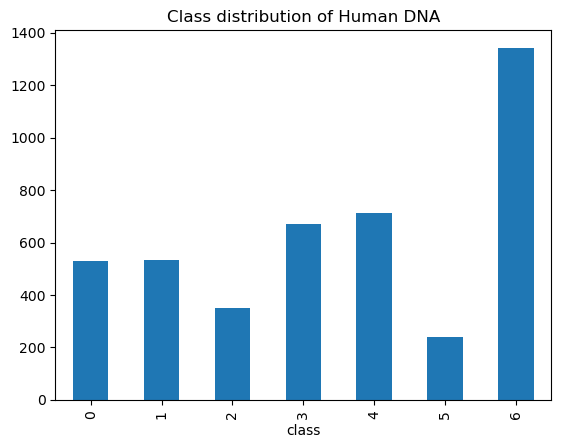

In [28]:
human_dna['class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of Human DNA")

Text(0.5, 1.0, 'Class distribution of Chimpanzee DNA')

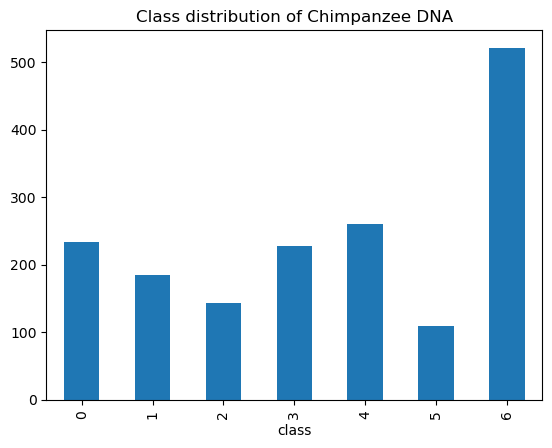

In [29]:
chimp_dna['class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of Chimpanzee DNA")

Text(0.5, 1.0, 'Class distribution of Dog DNA')

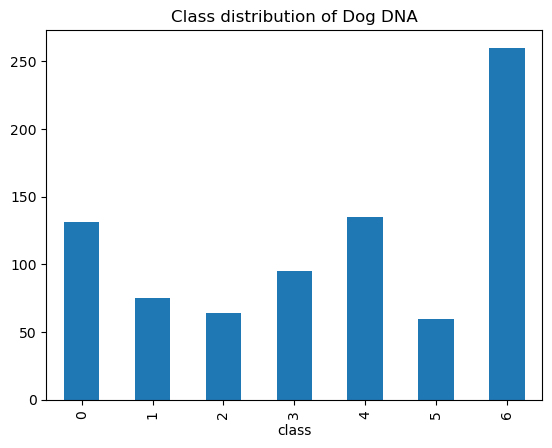

In [30]:
dog_dna['class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of Dog DNA")

There are similar distributions of classes so we will continue on with analysis.

To be able to perform a cluster analysis on this data, the sequences must be converted into shorter pieces. In genomic sequencing, substrings of length 'k' (k-mer) map the genome to provide a "signature" of each sequence so that alignment can be compared in pieces. The k-mers are made up of the nucleotides, essentially the letters of the DNA language. Breaking these down, it forms "words" that are overlapping. For example, if we use “words” with a length of 6 (hexamers), “ACTCGAGTCA” becomes: 'ACTCGA', 'CTCGAG', 'CGAGTC', 'GGAGTCA'. Therefore, the example sequence is broken down into 4 hexamer words.  The k-mers must then be vectorized,, best done with a bag-of-words model, to convert the k-mers into numerical representations. This process is called "k-mer counting" and NLP processing tools efficiently acheive this. 

1. Define k-mers function

In [31]:
def Kmers_funct(seq, size=6):  # designate the sequence and k-mer length (6)
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]  # convert all to lowercase; iterate over all sequences to  list all possible options for overlapping k-mers of 6; range ensures k-mers created for entirety of sequence

2. Apply k-mers function to sequences

In [32]:
human_dna['words'] = human_dna.apply(lambda x: Kmers_funct(x['sequence']), axis=1) # use lambda x to map each row and pass the function to each part of the sequence, axis = 1 applies the funciton to each row
chimp_dna['words'] = chimp_dna.apply(lambda x: Kmers_funct(x['sequence']), axis=1)
dog_dna['words'] = dog_dna.apply(lambda x: Kmers_funct(x['sequence']), axis=1)

3. Create list of strings for vectorizer and Bag of Words models. Transforming like this creates a feature matrix where each column represents a unique 4-gram of k-mers, and each row represents a DNA sequence.

In [33]:
# Creating a list of strings for CountVectorizer
human_texts = [' '.join(seq) for seq in human_dna['words']] # join k-mers into strings (sentences)
chimp_texts = [' '.join(seq) for seq in chimp_dna['words']]
dog_texts = [' '.join(seq) for seq in dog_dna['words']]

# Create the Bag of Words model
cv = CountVectorizer(ngram_range=(4,4)) # ngram organizes k-mers to evaluate individual and groups of k-mers
X = cv.fit_transform(human_texts) # fit and transform into feature vectors for model
X_chimp = cv.transform(chimp_texts) # transform into same feature spaces as human data
X_dog = cv.transform(dog_texts) # transform into same feature spaces as human data

The format of these matrices is sparse and is good for storing feature matricies when most of the elements are zeros following text vectorization. Each entry indicates the where the k-mer is located in a sequence. Given that the entry is (i, j), i is the sequence (row or index) and j is the k-mer (column). The value of the k-mer column is the count of that specific k-mer throughout the DNA sequence. 

In [34]:
print(X)
print(X_chimp)
print(X_dog)

  (0, 52803)	1
  (0, 207969)	1
  (0, 136621)	1
  (0, 79202)	1
  (0, 78295)	2
  (0, 74681)	2
  (0, 60650)	1
  (0, 6563)	1
  (0, 25724)	1
  (0, 101750)	1
  (0, 176196)	1
  (0, 3017)	1
  (0, 11772)	1
  (0, 46030)	1
  (0, 181326)	1
  (0, 25976)	1
  (0, 102780)	1
  (0, 180265)	1
  (0, 21456)	1
  (0, 84717)	1
  (0, 99209)	1
  (0, 163924)	1
  (0, 187178)	1
  (0, 53731)	1
  (0, 211749)	1
  :	:
  (4379, 198518)	1
  (4379, 164856)	1
  (4379, 150748)	1
  (4379, 134240)	1
  (4379, 212199)	1
  (4379, 153025)	1
  (4379, 142876)	1
  (4379, 103635)	1
  (4379, 19522)	1
  (4379, 39966)	1
  (4379, 157552)	1
  (4379, 232202)	1
  (4379, 231582)	1
  (4379, 15135)	1
  (4379, 20267)	1
  (4379, 79879)	1
  (4379, 80930)	1
  (4379, 105544)	1
  (4379, 227125)	1
  (4379, 132325)	1
  (4379, 156977)	1
  (4379, 17192)	1
  (4379, 115050)	1
  (4379, 98593)	1
  (4379, 170831)	1
  (0, 27)	1
  (0, 110)	1
  (0, 189)	1
  (0, 204)	1
  (0, 335)	1
  (0, 438)	1
  (0, 748)	1
  (0, 804)	1
  (0, 859)	1
  (0, 873)	1
  (0, 1317)	1
 

Now that we've prepared the feature matrices, we can attempt a clustering model. In order to do these across species, we have to concatenate the matrices.

In [35]:
# Combine data from all species
combined_data = vstack([X, X_chimp, X_dog])

Now we will perform k-means clustering with k=3, then use the elbow method to determine the optimal value of k by plotting the WCSS (within-cluster sum of squares)

K-means attempt 1

In [36]:
# Elbow method
# Combined_data is the combined sparse matrix
sum_of_squared_distances = []
K = range(1, 30)  # testing 1 to 30 clusters
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(combined_data)
    sum_of_squared_distances.append(km.inertia_)

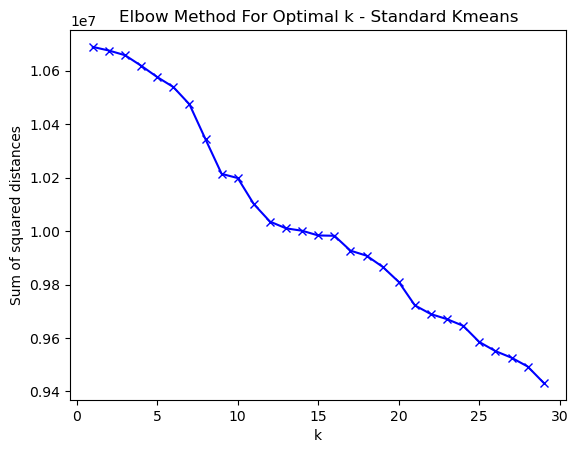

In [37]:
# Plotting
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k - Standard Kmeans')
plt.show()

In [38]:
# Perform K-Means Clustering
kmeans = KMeans(n_clusters=9, random_state=42) # Using 9 as optimal k based on plot
kmeans.fit(combined_data)

KMeans(n_clusters=9, random_state=42)

In [39]:
# Get the cluster labels
cluster_labels = kmeans.labels_

# Since we stacked the data in the order of human, chimp, and dog,
# the labels correspond to this order.

# Number of human sequences
num_human = X.shape[0]

# Number of chimp sequences
num_chimp = X_chimp.shape[0]

# Assign labels back to individual species datasets
human_labels = cluster_labels[:num_human]
chimp_labels = cluster_labels[num_human:num_human+num_chimp]
dog_labels = cluster_labels[num_human+num_chimp:]

# Adding these labels to the original dataframes:
human_dna['Cluster'] = human_labels
chimp_dna['Cluster'] = chimp_labels
dog_dna['Cluster'] = dog_labels

# Analyze the cluster distributions within each species
print("Human DNA Cluster Counts:")
print(human_dna['Cluster'].value_counts())

print("\nChimpanzee DNA Cluster Counts:")
print(chimp_dna['Cluster'].value_counts())

print("\nDog DNA Cluster Counts:")
print(dog_dna['Cluster'].value_counts())


Human DNA Cluster Counts:
Cluster
0    4286
8      48
7      12
4      10
2       8
3       8
5       7
6       1
Name: count, dtype: int64

Chimpanzee DNA Cluster Counts:
Cluster
0    1636
4      10
2       8
8       8
7       7
3       6
5       5
6       2
Name: count, dtype: int64

Dog DNA Cluster Counts:
Cluster
0    812
8      2
1      2
7      2
4      1
3      1
Name: count, dtype: int64


Cluster 0: As the dominant cluster across all species, this may contain highly conserved genetic sequences. This cluster's size signifies that a large portion of the DNA sequences have similar patterns, which could be essential genes shared across the species you've analyzed.

Clusters 1-8 (Humans): There are sequences that are unique enough to form separate clusters from the majority. This diversity within human DNA might reflect different gene families or functional groups.

Clusters 1-8 (Chimpanzees): Similar to humans, chimpanzees have a small number of sequences in these clusters, which might indicate unique or less conserved gene sequences.

Clusters 1-8 (Dogs): Dogs have even fewer sequences in these smaller clusters, but the presence of these clusters could still highlight interesting genetic differences.

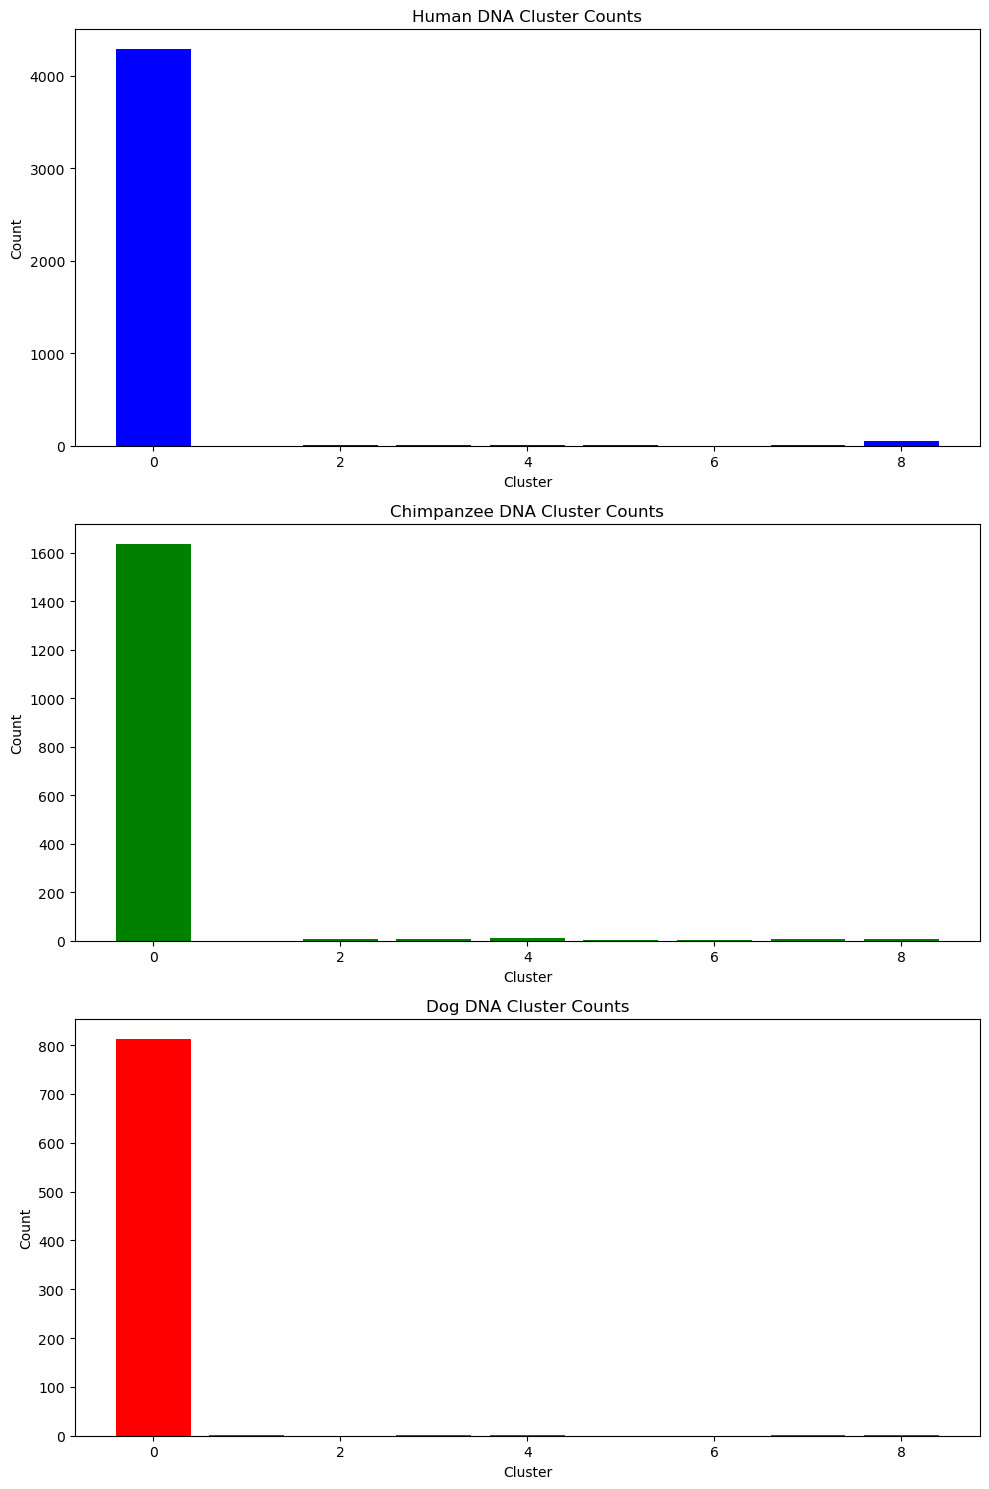

In [40]:
import matplotlib.pyplot as plt

# Converted cluster counts to dictionaries for plotting:
human_cluster_counts = {0: 4286, 8: 48, 7: 12, 4: 10, 2: 8, 3: 8, 5: 7, 6: 1}
chimp_cluster_counts = {0: 1636, 4: 10, 2: 8, 8: 8, 7: 7, 3: 6, 5: 5, 6: 2}
dog_cluster_counts = {0: 812, 8: 2, 1: 2, 7: 2, 4: 1, 3: 1}

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot for human DNA
axs[0].bar(human_cluster_counts.keys(), human_cluster_counts.values(), color='blue')
axs[0].set_title('Human DNA Cluster Counts')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Count')

# Plot for chimpanzee DNA
axs[1].bar(chimp_cluster_counts.keys(), chimp_cluster_counts.values(), color='green')
axs[1].set_title('Chimpanzee DNA Cluster Counts')
axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('Count')

# Plot for dog DNA
axs[2].bar(dog_cluster_counts.keys(), dog_cluster_counts.values(), color='red')
axs[2].set_title('Dog DNA Cluster Counts')
axs[2].set_xlabel('Cluster')
axs[2].set_ylabel('Count')

# Display the plots
plt.tight_layout()
plt.show()

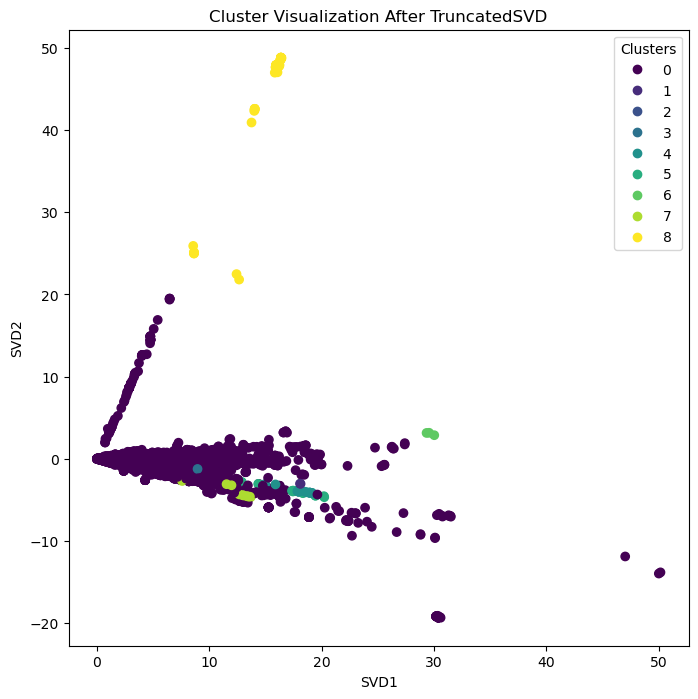

In [41]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Perform SVD on the combined data
svd = TruncatedSVD(n_components=2, random_state=42)
combined_data_reduced = svd.fit_transform(combined_data)

# Get labels from kmeans
cluster_labels = kmeans.labels_

# Plotting the results of SVD
plt.figure(figsize=(8, 8))
scatter = plt.scatter(combined_data_reduced[:, 0], combined_data_reduced[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Cluster Visualization After TruncatedSVD')
plt.xlabel('SVD1')
plt.ylabel('SVD2')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


These metrics were not viable due to the computational overload:

In [42]:
# Calinski-Harabasz Index
#calinski_harabasz = calinski_harabasz_score(combined_data, cluster_labels)
#print(f"Calinski-Harabasz Index: {calinski_harabasz}")

# Davies-Bouldin Index
#davies_bouldin = davies_bouldin_score(combined_data, cluster_labels)
#print(f"Davies-Bouldin Index: {davies_bouldin}")


In [43]:
# Convert data to dense for evaluating
dense_data = combined_data.toarray()

# Silhouette Score
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(dense_data, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.15943692351757888


K-means attempt 2 - mini can be better for larger datasets.

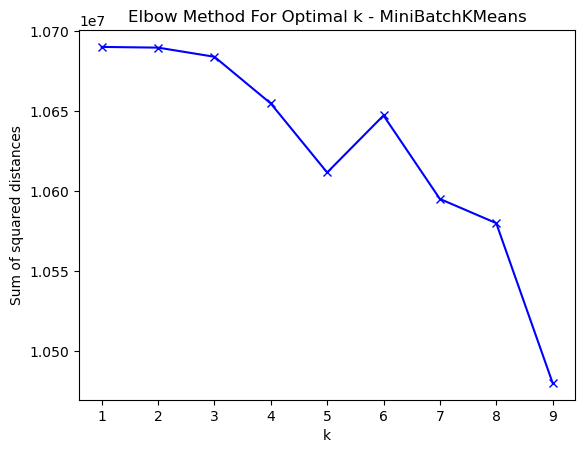

In [46]:
# Elbow method
# Combined_data is the combined sparse matrix
sum_of_squared_distances = []
K = range(1, 10)  # testing 1 to 10 clusters
for k in K:
    km = MiniBatchKMeans(n_clusters=k, random_state=42)
    km = km.fit(combined_data)
    sum_of_squared_distances.append(km.inertia_)

# Plotting
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k - MiniBatchKMeans')
plt.show()

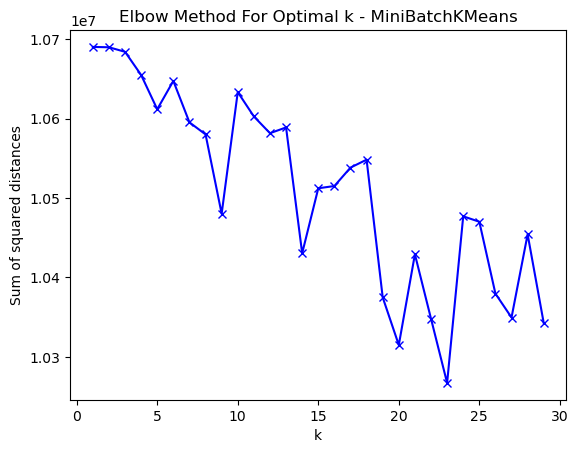

In [48]:
# Elbow method
# Combined_data is the combined sparse matrix
sum_of_squared_distances = []
K = range(1, 30)  # testing 1 to 10 clusters
for k in K:
    km = MiniBatchKMeans(n_clusters=k, random_state=42)
    km = km.fit(combined_data)
    sum_of_squared_distances.append(km.inertia_)

# Plotting
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k - MiniBatchKMeans')
plt.show()The largest drop 

This method does not have a clear elbow to it, so the optimal k is difficult to determine. The first elbow in this range could be identified as 9 as well, so I'll attempt to use that. 

In [59]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=9, random_state=42) # using 17
kmeans.fit(combined_data)

MiniBatchKMeans(n_clusters=9, random_state=42)

In [60]:
# Get the cluster labels
cluster_labels = kmeans.labels_

# Since we stacked the data in the order of human, chimp, and dog,
# the labels correspond to this order.

# Number of human sequences
num_human = X.shape[0]

# Number of chimp sequences
num_chimp = X_chimp.shape[0]

# Assign labels back to individual species datasets
human_labels = cluster_labels[:num_human]
chimp_labels = cluster_labels[num_human:num_human+num_chimp]
dog_labels = cluster_labels[num_human+num_chimp:]

# Adding these labels to the original dataframes:
human_dna['Cluster'] = human_labels
chimp_dna['Cluster'] = chimp_labels
dog_dna['Cluster'] = dog_labels

# Analyze the cluster distributions within each species
print("Human DNA Cluster Counts:")
print(human_dna['Cluster'].value_counts())

print("\nChimpanzee DNA Cluster Counts:")
print(chimp_dna['Cluster'].value_counts())

print("\nDog DNA Cluster Counts:")
print(dog_dna['Cluster'].value_counts())

Human DNA Cluster Counts:
Cluster
1    4291
3      48
4      13
5       6
0       6
2       5
8       5
7       4
6       2
Name: count, dtype: int64

Chimpanzee DNA Cluster Counts:
Cluster
1    1657
4       8
3       7
2       4
6       2
7       2
8       2
Name: count, dtype: int64

Dog DNA Cluster Counts:
Cluster
1    817
0      1
6      1
2      1
Name: count, dtype: int64


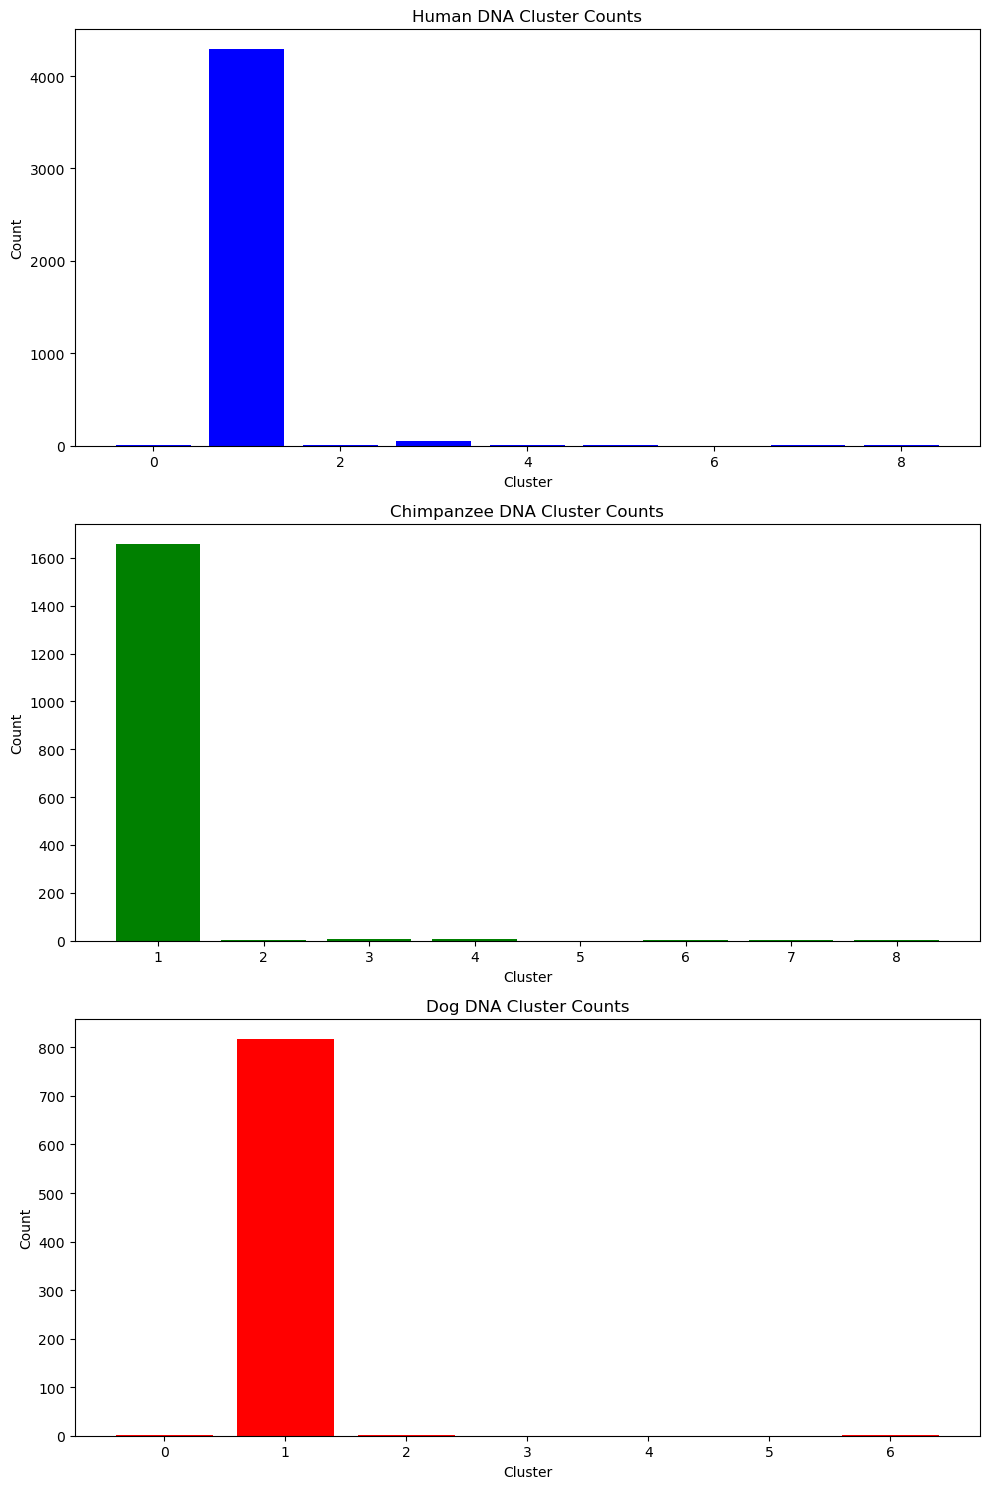

In [61]:
import matplotlib.pyplot as plt

# Converted cluster counts to dictionaries for plotting:
# Converted cluster counts to dictionaries for plotting:
human_cluster_counts = {1: 4291, 3: 48, 4: 13, 5: 6, 0: 6, 2: 5, 8: 5, 7: 4, 6: 2}
chimp_cluster_counts = { 1: 1657, 4: 8, 3: 7, 2: 4, 6: 2, 7: 2, 8: 2}
dog_cluster_counts = {1: 817, 0: 1, 6: 1, 2:1}

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot for human DNA
axs[0].bar(human_cluster_counts.keys(), human_cluster_counts.values(), color='blue')
axs[0].set_title('Human DNA Cluster Counts')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Count')

# Plot for chimpanzee DNA
axs[1].bar(chimp_cluster_counts.keys(), chimp_cluster_counts.values(), color='green')
axs[1].set_title('Chimpanzee DNA Cluster Counts')
axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('Count')

# Plot for dog DNA
axs[2].bar(dog_cluster_counts.keys(), dog_cluster_counts.values(), color='red')
axs[2].set_title('Dog DNA Cluster Counts')
axs[2].set_xlabel('Cluster')
axs[2].set_ylabel('Count')

# Display the plots
plt.tight_layout()
plt.show()

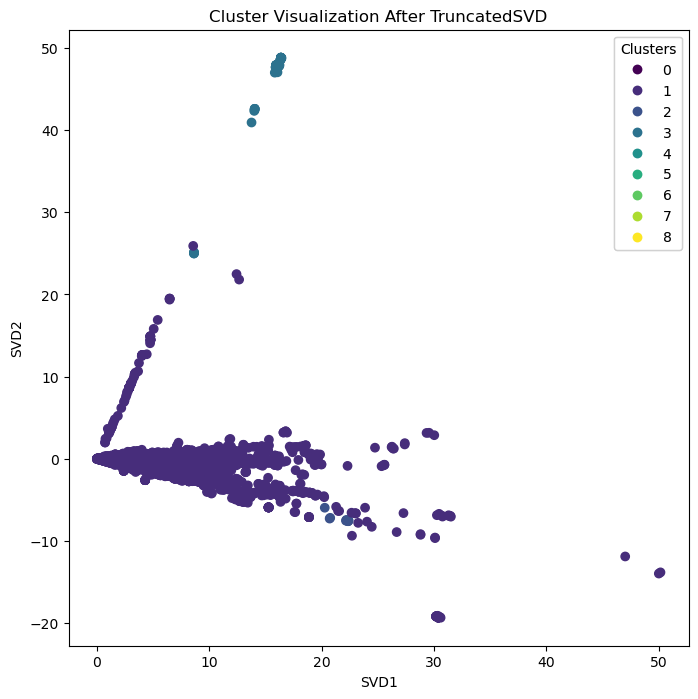

In [62]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Ensure you have your data ready in `combined_data` and `kmeans` is already fitted to this data.

# Perform SVD on the combined data
svd = TruncatedSVD(n_components=2, random_state=42)
combined_data_reduced = svd.fit_transform(combined_data)

# Get labels from kmeans
cluster_labels = kmeans.labels_

# Plotting the results of SVD
plt.figure(figsize=(8, 8))
scatter = plt.scatter(combined_data_reduced[:, 0], combined_data_reduced[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Cluster Visualization After TruncatedSVD')
plt.xlabel('SVD1')
plt.ylabel('SVD2')

# Create a legend
# If there are too many clusters, you might want to handle the legend outside the plotting area or skip it.
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters", loc="best")
plt.gca().add_artist(legend1)

plt.show()

Upon examining the scatter plots generated from the singular value decomposition (SVD) of the genetic sequences for humans, dogs, and chimps, we observe distinct clustering patterns that reveal insights into the genetic similarities and differences among these species. This analysis is based on the assumption that the SVD was used to reduce the dimensionality of a similarity matrix derived from genetic sequences, and that the clusters represent groups of similar sequences. The counts of sequences in each cluster suggest the prevalence of certain genetic motifs within the population. However, to provide a more detailed analysis, additional biological context would be required.

Human Genetic Clustering: The human genetic data shows a dominant cluster, which we've labeled as Cluster 1, encompassing a significant majority of the sequences with 4298 instances. This suggests a high degree of conservation in certain genetic regions within the human samples. The presence of smaller clusters and isolated points indicates variability in other genetic regions, possibly corresponding to less conserved sequences or those that are subject to greater evolutionary pressures.

Chimpanzee Genetic Clustering: The chimpanzee data also exhibits a primary cluster, with Cluster 1 containing 1646 sequences. The distribution and count of the clusters are less dense compared to humans, reflecting the genetic diversity present within the chimpanzee sequences. The scattered nature of the smaller clusters suggests a variety of genetic functions or differences within the chimp genome.

Dog Genetic Clustering: The canine sequences demonstrate a very distinct pattern, with a primary cluster (Cluster 1 with 811 sequences) and several minor clusters or single instances. The spread of clusters is indicative of the genetic diversity within the dog population, possibly due to the extensive breeding and variation seen in domesticated dogs.

The clustering patterns provide a visual representation of the genetic relationships within and between species. It is evident from the plots that there is a significant overlap in genetic sequences between humans and chimps, which is to be expected given their close evolutionary relationship. The dog sequences, while distinct, still show a pattern of clustering, which might correspond to conserved sequences that are essential across mammalian species.

Overall, the clustering analysis has the potential to identify regions of genetic similarity and divergence, which can further our understanding of genetic evolution and the underlying biological functions of these sequences. Future analysis could involve annotating these clusters with biological data to ascertain the functional similarities within clusters and the evolutionary significance of the sequences that fall outside of the primary clusters.
